After completing the attention heads and combining attention heads to form multi-headed attention mechanism. Now, we will form the surrounding tranformer architecture to support the GPT model. So in the book, a dummy model is created first without containing any functionality in it, just to explain how the structre of a GPT model works. First the input is tokenized, them embedded, then runs through multiple attention head mechanisms, linear output layers and then decoded back to tokens. 

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

"vocab_size" indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in Chapter 2
"context_length" represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2
"emb_dim" is the embedding size for token inputs, converting each input token into a 768-dimensional vector
"n_heads" is the number of attention heads in the multi-head attention mechanism implemented in Chapter 3
"n_layers" is the number of transformer blocks within the model, which we'll implement in upcoming sections
"drop_rate" is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
"qkv_bias" decides if the Linear layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs;

In [2]:
import torch
import torch.nn as nn
import tiktoken

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.position_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.transformer_blocks = nn.Sequential(
            *[DummyTransformerBlocks(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
        
    def forward(self, index):
        batch_size, seq_len = index.shape
        token_embeds = self.token_emb(index)
        position_embeds = self.position_emb(torch.arange(seq_len, device = index.device))
        x = token_embeds + position_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlocks(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        
    def forward(self, x):
        return x
            

THe above cell contains the skeleton of a Dummy GPT model, this is how it would look, the classes of transformer blocks and normalization layers are not complete yet, those will be formed step by step by learning.

In [4]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []

text1 = "Life is a"
text2 = "always believe in"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)
print(batch)

/home/salaj/anaconda3/envs/dl-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


tensor([[14662,   318,   257],
        [33770,  1975,   287]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 3, 50257])
tensor([[[-0.4662,  0.3252, -0.0501,  ..., -0.4346,  0.7034,  0.3292],
         [-0.3497, -0.1606, -0.4492,  ..., -0.5948,  0.3007,  0.0621],
         [ 0.0887, -0.9600,  0.1678,  ...,  0.6472,  0.1326, -0.1579]],

        [[-0.4402,  0.3932, -1.4061,  ..., -0.2005,  0.6720, -0.8172],
         [ 0.2087,  0.6763, -0.2571,  ...,  0.1412, -0.1501, -0.0122],
         [-0.1937,  2.7545, -0.0680,  ...,  0.3875, -0.0067,  0.7153]]],
       grad_fn=<UnsafeViewBackward0>)


After completing this dummy skeleton of a GPT model, let's create the Normalization layer. The role of normalization is to stabilize training and enable faster convergance of the weights. Basically applying normalization after each attention layer, allows us to bring the mean of the outputs to 0 and the variance to 1 which allows us to keep the outputs on the same page after each layer. So reducing possible places of problems.

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,6)
layer = nn.Sequential(nn.Linear(6,8), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.0000, 0.0000, 0.3391, 0.1583, 0.0000, 0.0000, 0.4158, 0.0176],
        [0.0000, 0.0000, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000, 0.2426]],
       grad_fn=<ReluBackward0>)

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1163],
        [0.1012]], grad_fn=<MeanBackward1>)
tensor([[0.0293],
        [0.0427]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print(out_norm)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

tensor([[-0.6800, -0.6800,  1.3018,  0.2451, -0.6800, -0.6800,  1.7501, -0.5771],
        [-0.4901, -0.4901,  2.2562, -0.4901, -0.4901, -0.4901, -0.4901,  0.6843]],
       grad_fn=<DivBackward0>)
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim = True, unbiased = False)
        norm_x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

Some features we have used here:
eps - When the variance of a row might be 0 then while calculating the norm, it would be dividing by zero, so we apply a very small epsilon so that it is not undefined. 
scale and shift - If during the training, the model finds that the norm_x is deviating from its expected value then the parameters of scale and shift are changed so that it brings back the mean to 0 and the var to 1. 

In [10]:
ln = LayerNorm(emb_dim=6)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print(mean)
print(var)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Layer normalization is a very important part, other than that after the attention mechanism has completed its work and the layer has been normalized, each token is run through a feed forward block also called a Multi layer perceptron. One of the key components of this MLP layer is the activation functions. For general purposes, ReLU is the most common used activation function but ReLU has a very high degree of change on 0. For all negative values ReLU just outputs 0 and for all positive values it outputs the same. Due to the sharp corner at zero, it makes optimization harder for ReLU. So, we use another activation function known as the Gaussian Error Linear Unit (GELU). The simpler approxitmation of the GELU to make it computationally affordable is GELU(x) ≈ 0.5 ⋅ x ⋅ (1 + tanh[√((2/π)) ⋅ x + 0.044715 ⋅ x^3]). Below is the graph of ReLU and GELU for comparision and the implementation of GELU in a class. 

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.44715 * torch.pow(x, 3))))

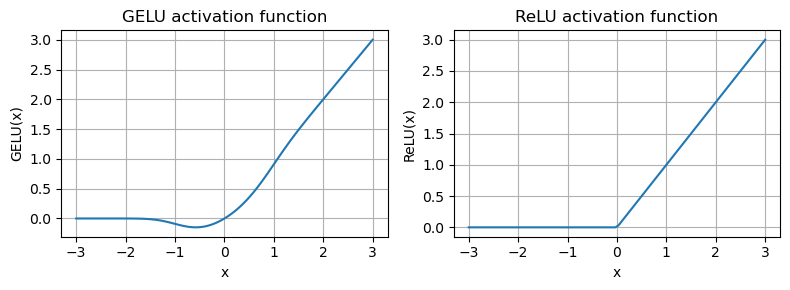

In [12]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

Yeah, so the only difference in ReLU and GELU is the negative part, Relu doesnt allow negative values to affect the gradients whereas GELU allows negative values close to 0 affect the gradients but very minimal changes. Now we will use this GELU activation to define a feed forward layer.

In [13]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(), 
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
output = ffn(x)
print(output)
print(output.shape)

tensor([[[-0.1834, -0.0548, -0.1705,  ..., -0.0473,  0.0449,  0.0005],
         [-0.0770, -0.0994, -0.1524,  ..., -0.0071,  0.0560,  0.0871],
         [-0.1177, -0.0036, -0.1050,  ...,  0.0490, -0.0769,  0.0299]],

        [[-0.1002, -0.0065, -0.1014,  ...,  0.0550, -0.0687, -0.0235],
         [-0.1782, -0.0862, -0.1239,  ..., -0.0621, -0.0082,  0.0631],
         [-0.1581, -0.1387, -0.1162,  ..., -0.0122,  0.0346,  0.0860]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 768])


What we basically did here is, initially the dimension of each vector was 768, we increase that to 768 x 4. Allowing each element to take a much bigger space in the high-dimension vector space and expand its meaning, apply the GELU activation on it and then contract it back again to 768 dimensions. So the intial and final dimensions of the vector are same, but this allows each token to explore a bigger space and a richer representation space. 

ANother important functionality we use is the shortcut connections. It tries to solve the vanishing gradient problem. Imagine a glass of water from which water is being transfered to another glass with some recklessness, after repeating this for 9-10 times the water in the last glass would be very less. THis is exactly what happens in vanishing gradient, the value of the gradient in the first layer is almost zero and makes no differnece, so we add connections from the last layer to different layers in between skipping the layers in betwwen to provide effective gradient in each layers. We will directly apply this in the implementation.

In [14]:
from important_GPT_blocks import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )        
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) 
        x = self.drop_shortcut(x)
        x = x + shortcut  

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x
    
torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


This is the complete implementation of the original transformer block. Now using this transformer, the normalization layer and other components we complete the GPT model.

In [15]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[14662,   318,   257],
        [33770,  1975,   287]])

Output shape: torch.Size([2, 3, 50257])
tensor([[[ 0.4906,  0.1367,  0.7441,  ..., -0.5264,  1.2308, -0.1062],
         [ 0.6807, -1.3219, -0.3639,  ..., -0.5586,  0.5617, -0.0524],
         [ 1.4803,  0.4686,  0.6771,  ...,  0.3952, -0.2109,  0.4363]],

        [[-0.4005,  0.4785,  0.3106,  ...,  0.4435,  0.7553, -0.0831],
         [ 0.7394, -0.5542,  0.4247,  ..., -0.3514,  0.0794, -0.3447],
         [ 0.8821,  0.5700, -0.1765,  ...,  0.0035,  0.3378, -0.0520]]],
       grad_fn=<UnsafeViewBackward0>)


In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


The total number of parameters for out model are near 163 million. For the GPT-3 model it is 175 billion!!!

Now i am experimenting with the number of layers and heads to see how it affects the parameters.    

In [18]:

GPT_Experiment_1 = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 24,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

exp_model_1 = GPTModel(GPT_Experiment_1)
output = exp_model_1(batch)
exp_parameters = sum(p.numel() for p in exp_model_1.parameters())
print(f"Parameters : {exp_parameters:,}")

Parameters : 333,063,168


In [19]:

GPT_Experiment_1 = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 128,          # Number of attention heads
    "n_layers": 256,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

exp_model_1 = GPTModel(GPT_Experiment_1)
output = exp_model_1(batch)
exp_parameters = sum(p.numel() for p in exp_model_1.parameters())
print(f"Parameters : {exp_parameters:,}")

Parameters : 1,891,888,128


Now we use the decoding part which allows us to convert the finally generated output vectors to get converted to tokens and words. 

In [20]:
def simple_text_gen(model, idx, max_tokens, context_size):
    for _ in range(max_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probabilities = torch.softmax(logits, dim =-1)
        idx_nxt = torch.argmax(probabilities, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_nxt), dim=1)
    return idx

In [21]:
start = "This is business"
encoded = tokenizer.encode(start)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)


[1212, 318, 1597]


In [22]:
model.eval()

out = simple_text_gen(model=model, idx = encoded_tensor, max_tokens=5, context_size=GPT_CONFIG_124M['context_length'])
out

tensor([[ 1212,   318,  1597, 11354, 16846, 24086, 47843, 30961]])

In [25]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

This is business fer packagingiman Byeswick


Pure Nonsense :)